# Import

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
from matplotlib import cm
from matplotlib.colors import Normalize 
from scipy.interpolate import interpn
import pandas as pd
import tensorflow as tf
%matplotlib inline
from tensorflow.keras.models import Sequential, Model
import os

os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '2,3,4'

gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

def binarange(arr, binsize=0.01, minimo=None, maximo=None):
    if minimo==None:
        minimo=min(arr)
    if maximo==None:
        maximo=max(arr)+binsize
    return np.arange(minimo, maximo, binsize)

color_list = list(mpl.colors.TABLEAU_COLORS)

In [2]:
def mkdir(directory_path): 
    if os.path.exists(directory_path): 
        return directory_path
    else: 
        try: 
            os.makedirs(directory_path)
        except: 
            # in case another machine created the path meanwhile !:(
            return sys.exit("Erro ao criar diretório") 
        return directory_path

# Load Data - Entire PDFs

Carrega as PDFs normalizadas vindas do modelo MDNm. Além disso também carrega os metadados que contem o spec-z de cada objeto.

obs: dados muito pesados para o github, em caso de testes pode entrar em contato pelo email gteixeira@cbpf.br


In [90]:
data_dir = '/tf/dados10T/gabriel/photoz_paper/datasets_results/'

dataset_name = 'E'
train_idx = np.load('/tf/dados10T/gabriel/photoz_paper/datasets/'+'train_idx.npy')
train_metadata = pd.read_csv(data_dir.replace('_results', '') + f'train_dataset_{dataset_name}'+ '.csv')[train_idx]
test_metadata = pd.read_csv(data_dir.replace('_results', '') + f'test_dataset_A_desiphotometry'+ '.csv')


train_data = {}
train_data['pdf'] = np.load(data_dir + 'dataset_'+dataset_name+'normalized_pdfs_TRAIN.npy')
train_data['photoz'] = np.load(data_dir + 'dataset_'+dataset_name+'photo_z_TRAIN.npy')

test_data = {}
test_data['pdf'] = np.load(data_dir + 'dataset_'+dataset_name+'normalized_pdfs.npy')
test_data['photoz'] = np.load(data_dir + 'dataset_'+dataset_name+'photo_z.npy')
spec_z_test = np.array(test_metadata['z_spec'])

Text(0, 0.5, 'Mean PDF')

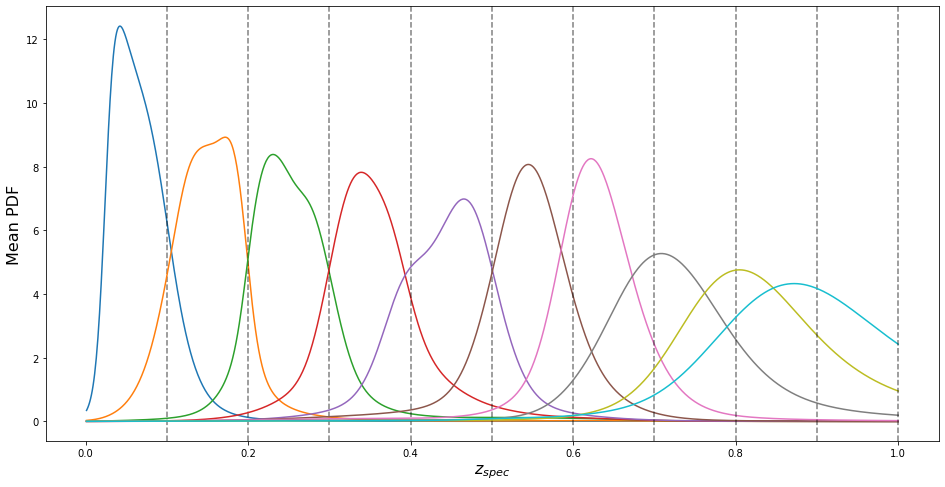

In [98]:
# visão geral das pdfs a partir da média delas por bins de spec-z (width 0.1)

fig = plt.figure(figsize=(16,8))
zstep = 0.1
zaxis = np.linspace(0.001, 1, 1000)
for z in np.arange(0,1,zstep):
    inrange_train = train_metadata['z_spec'].between(z, z+0.1)
    train_pdfs_bin =  train_data['pdf'][np.array(inrange_train)]
    plt.plot(zaxis,np.mean(train_pdfs_bin, axis=0))
    plt.axvline(z+zstep, ls='--', alpha=0.5, c='k')
plt.xlabel('$z_{spec}$', fontsize=16)
plt.ylabel('Mean PDF', fontsize=16)

# Preprocessing PDFs

Divide as pdfs por sua soma para que no fim, a soma de todas as entradas seja 1

In [92]:
#preprocessing
train_data['pdf_preproc'] = np.zeros((len(train_data['pdf']), 1000, 1))
test_data['pdf_preproc'] = np.zeros((len(test_data['pdf']), 1000, 1))

for i in range(len(train_data['pdf'])):
    train_data['pdf_preproc'][i] = (train_data['pdf'][i]/np.sum(train_data['pdf'][i])).reshape(-1,1)
    
for i in range(len(test_data['pdf'])):
    test_data['pdf_preproc'][i] = (test_data['pdf'][i]/np.sum(test_data['pdf'][i])).reshape(-1,1)

In [93]:
# separa os conjuntos de treino teste e validação, alem disso retira uma dimensão extra que o array adquiriu durante a etapa anterior
np.random.seed(42)
val_size = 0.1
val_idx = np.random.uniform(0,1,len(train_data['pdf_preproc'])) < 0.1

x_train_uni = np.squeeze(train_data['pdf_preproc'][~val_idx], axis=-1)
x_val_uni = np.squeeze(train_data['pdf_preproc'][val_idx], axis=-1)
x_test_uni = np.squeeze(test_data['pdf_preproc'], axis=-1)

In [96]:
print(len(x_train_uni))
print(len(x_val_uni))
print(len(x_test_uni))

647981
71862
503606


In [ ]:
from tensorflow.keras.utils import Sequence
class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y

train_gen = DataGenerator(x_train_uni, x_train_uni, 256)
val_gen = DataGenerator(x_val_uni, x_val_uni, 256)


In [ ]:
history = autoencoder.fit(train_gen, validation_data=val_gen, epochs=60)

Epoch 1/60
20250/20250 [==============================] - 139s 7ms/step - loss: 7.3539e-06 - val_loss: 1.3240e-06
Epoch 2/60
20250/20250 [==============================] - 142s 7ms/step - loss: 6.7974e-07 - val_loss: 4.0600e-07
Epoch 3/60
20250/20250 [==============================] - 141s 7ms/step - loss: 3.0916e-07 - val_loss: 2.3515e-07
Epoch 4/60
20250/20250 [==============================] - 139s 7ms/step - loss: 2.0238e-07 - val_loss: 1.8372e-07
Epoch 5/60
20250/20250 [==============================] - 140s 7ms/step - loss: 1.7768e-07 - val_loss: 1.7072e-07
Epoch 6/60
20250/20250 [==============================] - 142s 7ms/step - loss: 1.6875e-07 - val_loss: 1.6405e-07
Epoch 7/60
20250/20250 [==============================] - 141s 7ms/step - loss: 1.6105e-07 - val_loss: 1.5619e-07
Epoch 8/60
20250/20250 [==============================] - 143s 7ms/step - loss: 1.5401e-07 - val_loss: 1.4326e-07
Epoch 9/60
20250/20250 [==============================] - 142s 7ms/step - loss: 1.4456e-

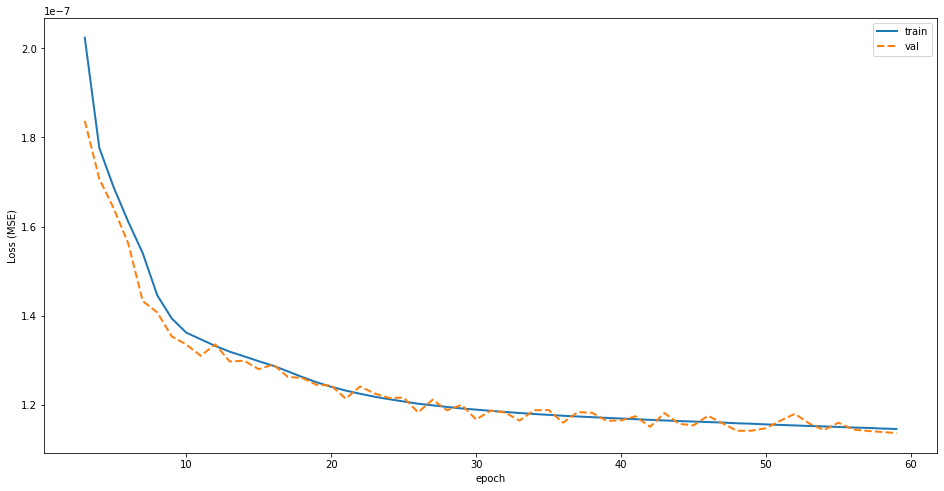

In [ ]:
fig = plt.figure(figsize=(16, 8))
color_list = list(mpl.colors.TABLEAU_COLORS)


initial_epoch = 3
epochs = range(len(history.history['loss']))
plt.plot(epochs[initial_epoch:], history.history['loss'][initial_epoch:], c=color_list[0], ls='-', lw=2, label='train')
plt.plot(epochs[initial_epoch:], history.history['val_loss'][initial_epoch:], c=color_list[1], ls='--', lw=2, label='val')

    
plt.xlabel('epoch')
plt.ylabel('Loss (MSE)')
plt.legend()

# Multi-Train - Building Models

Criando 4 autoencoders com diferentes tamanhos de espaço latente

SPOILER ALERT! O modelo correspondente ao espaço latente de 40 deu insanamente errado, sinta-se livre para checar!

In [101]:
latent_sizes = [60,54,40,20]
# definindo os modelo por dicionários
Encoders = {}
Decoders = {}
Autoencoders = {}

for size in latent_sizes:
    feature_size = size
    input_dim = x_train_uni.shape[1:]
    name = 'size_'+str(size)

    Encoders[name] = Sequential([
        Dense(256, activation='linear', input_shape=input_dim),
        Dense(128, activation='linear'),
    #     Dense(50, activation='linear'),
        Dense(feature_size, activation='linear')
    #     Dense(latent_dim, activation='relu', input_shape=(input_dim,))
    ])

    Decoders[name] = Sequential([
        Dense(128, activation='linear', input_shape=(feature_size,)),
        Dense(256, activation='linear'),
    #     Dense(50, activation ='linear'),
        Dense(input_dim[0], activation='softmax')
    #     Dense(input_dim, activation='relu', input_shape=(latent_dim,))
    ])

    Autoencoders[name] = Model(inputs=Encoders[name].input, outputs=Decoders[name](Encoders[name].output))
    Autoencoders[name].compile(loss='mse', optimizer='Nadam')

In [132]:
#defining callbacks

EPOCHS = 100
checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

# Model weights are saved at the end of every epoch, if it's the best seen
# so far.
model.fit(epochs=EPOCHS, callbacks=[model_checkpoint_callback])

NameError: name 'model' is not defined

In [141]:
# Treinando os modelos e salvando os de menor loss de validação

My_Fits = {}
EPOCHS=50
mkdir(f'/tf/dados10T/gabriel/astroinfo')
for size in latent_sizes:
    name = 'size_'+str(size)
    
    checkpoint_filepath = f'/tf/dados10T/gabriel/astroinfo/my_best_model_{name}.hdf5'
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    # save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)
    callbacks = [checkpoint]
    
    My_Fits[name] = Autoencoders[name].fit(train_gen, validation_data=val_gen, epochs=EPOCHS, callbacks=callbacks)
    

Epoch 1/50
2532/2532 [==============================] - 24s 9ms/step - loss: 1.0509e-05 - val_loss: 1.0317e-05
Epoch 2/50
2532/2532 [==============================] - 22s 9ms/step - loss: 1.0340e-05 - val_loss: 1.0306e-05
Epoch 3/50
2532/2532 [==============================] - 23s 9ms/step - loss: 1.0336e-05 - val_loss: 1.0302e-05
Epoch 4/50
2532/2532 [==============================] - 23s 9ms/step - loss: 1.0330e-05 - val_loss: 1.0294e-05
Epoch 5/50
2532/2532 [==============================] - 23s 9ms/step - loss: 1.0315e-05 - val_loss: 1.0262e-05
Epoch 6/50
2532/2532 [==============================] - 23s 9ms/step - loss: 8.9956e-06 - val_loss: 4.6518e-06
Epoch 7/50
2532/2532 [==============================] - 22s 9ms/step - loss: 1.6812e-06 - val_loss: 1.3904e-06
Epoch 8/50
2532/2532 [==============================] - 23s 9ms/step - loss: 1.3114e-06 - val_loss: 1.2396e-06
Epoch 9/50
2532/2532 [==============================] - 23s 9ms/step - loss: 1.1724e-06 - val_loss: 1.1190e-06
E

In [102]:
# CASO JÁ TENHA TREINADO! 
# sinta-se livre para pegar os modelos já treinados comigo pelo email gteixeira@cbpf.br
load_weights = True

if load_weights:
    for size in latent_sizes:
        name = 'size_'+str(size)
        Autoencoders[name].load_weights(f'/tf/dados10T/gabriel/astroinfo/my_best_model_{name}.hdf5')

Text(0, 0.5, 'Loss (MSE)')

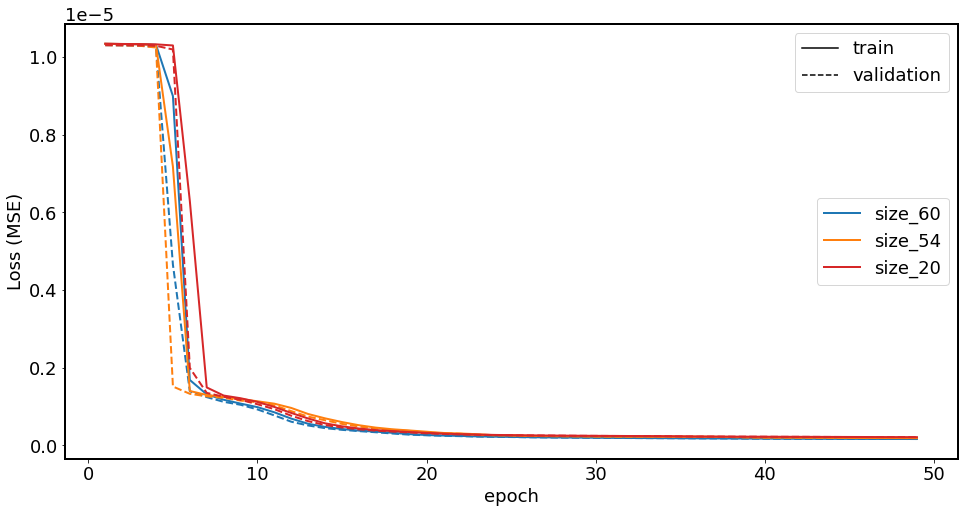

In [155]:
#plotando as losses

fig = plt.figure(figsize=(16, 8))
color_list = list(mpl.colors.TABLEAU_COLORS)


initial_epoch = 1



for i, size in enumerate(latent_sizes): 
    if size!=40:
        name = 'size_'+str(size)

        epochs = range(len(My_Fits[name].history['loss']))
        plt.plot(epochs[initial_epoch:], My_Fits[name].history['loss'][initial_epoch:], c=color_list[i], ls='-', lw=2, label=name)
        plt.plot(epochs[initial_epoch:], My_Fits[name].history['val_loss'][initial_epoch:], c=color_list[i], ls='--', lw=2)


solid = plt.Line2D([0,1],[0,1],linestyle='-', color='black')
dashed = plt.Line2D([0,1],[0,1],linestyle='--', color='black')


lineslegends = plt.legend([solid,dashed], ['train', 'validation'], loc='best')
plt.gca().add_artist(lineslegends)
plt.legend(loc='center right')
plt.xlabel('epoch')
plt.ylabel('Loss (MSE)')


# Multi-Inferences

realiza a inferencia das pdfs para teste do modelo

In [104]:
#infere e normaliza as pdfs
My_Latent = {}
My_PDFs = {}
My_Photoz = {}
for size in latent_sizes:
    name = 'size_'+str(size)
    
    My_Latent[name] = Encoders[name].predict(x_test_uni,  batch_size=256)
    My_PDFs[name] = Decoders[name].predict(My_Latent[name],  batch_size=256)
    My_Photoz[name] = zaxis[My_PDFs[name].argmax(axis=1)]
    My_PDFs['normalized-'+name] = My_PDFs[name]/np.trapz(My_PDFs[name], zaxis, axis=1).reshape(-1,1)#np.vstack([np.trapz(My_PDFs[name], x, axis=1)]*My_PDFs[name].shape[1]).T


    
        

1968/1968 [==============================] - 2s 1ms/step


In [ ]:
#calcula os erros como sendo a meia-largura do intervalo que contem 68% de confiança em z

def pdf_s68(pdf, interval, z_axis):
    areas = pdf*interval
    p16=0
    p84=0
    
    p16_lock = 0
    p84_lock = 0
    for i in range(len(areas)):
        
        
        p16+=areas[i]
        if p16>=15.85/100 and p16_lock==0:
            p16_final = z_axis[i]
            p16_lock = 1
            
        p84+=areas[-(1+i)]
        if p84>=(100-84.05)/100 and p84_lock==0:
            p84_final = z_axis[len(areas) - (i+1)]
            p84_lock = 1
       
        if p84_lock*p16_lock:
            break
    s68 = 0.5*(p84_final-p16_final)
    return s68


My_Errors = {}

for size in latent_sizes:
    name = 'size_'+str(size)
    
    My_Errors[name] = np.zeros(len(My_PDFs['normalized-'+name]))
    for i in range(len(My_PDFs['normalized-'+name])):
        My_Errors[name][i] =  pdf_s68(My_PDFs['normalized-'+name][i], interval = zaxis[2]-zaxis[1], z_axis=zaxis)
# to_compare_mdn = np.concatenate([photo_z.reshape(-1,1), s68_erros.reshape(-1,1)], axis=1)

normalized_x_test = x_test_uni/np.trapz(x_test_uni, zaxis, axis=1).reshape(-1,1)

In [187]:
My_Errors['test'] = np.zeros(len(normalized_x_test))
for i in range(len(x_test_uni)):
    My_Errors['test'][i] =  pdf_s68(normalized_x_test[i], interval = zaxis[2]-zaxis[1], z_axis=zaxis)

(0.0, 0.002)

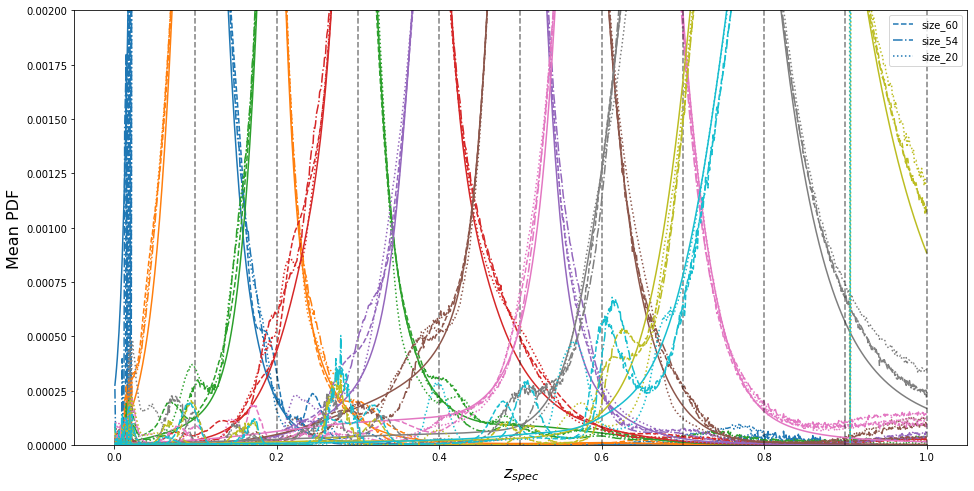

In [135]:
# Visualização das PDFs 
# sinta-se livre para mudar o ylim. Neste caso está assim pois é só nessa região de baixa probabilidade que vemos anomalias nas predições

fig = plt.figure(figsize=(16,8))
zstep = 0.1
zaxis = np.linspace(0.001, 1, 1000)
i=0
line_list = ['--', '-.', ':']

for z in np.arange(0,1,zstep):
    inrange_train = test_metadata['z_spec'].between(z, z+0.1)
    test_pdfs_bin =  x_test_uni[np.array(inrange_train)]
    l=0
    for size in latent_sizes[:]:
        if size!=40:
            name = 'size_'+str(size)

            predict_pdfs_bin =  My_PDFs[name][np.array(inrange_train)]
            plt.plot(zaxis,np.mean(predict_pdfs_bin, axis=0), ls=line_list[l], c=color_list[i], label=name)
            l+=1
    plt.plot(zaxis,np.mean(test_pdfs_bin, axis=0), c = color_list[i])
    plt.axvline(z+zstep, ls='--', alpha=0.5, c='k')
    
    if i==0:
        plt.legend()
    
    i+=1
plt.xlabel('$z_{spec}$', fontsize=16)
plt.ylabel('Mean PDF', fontsize=16)
plt.ylim(0,0.002)

# Kullback-Leiber Divergence

$$
D(q(x)|p(x)) = \int^{\infty}_{-\infty} q(x)log(q(x)/p(x))dx
$$

In [ ]:
def kbl_divergence(p, q, x):
    '''
    Implements the Kullback-Leibler divergence D(p|q);
    Parameters:
    np.array, p    :   N-dimensional array containing the PDF p(x)      
    np.array, q    :   N-dimensional array containing the PDF q(x) 
    np.array, x    :   N-dimensional array containing the x values os p and q.     

    Returns de Kullback-Leibler divergence D(p|q)

    Dependencies: numpy
    '''
    dx=x[1]-x[0]
    
    pnz = np.where(p>0, p, 1e-20)
    qnz = np.where(q>0, q, 1e-20)
    
    return (np.sum(pnz*np.log(pnz))-np.sum(pnz*np.log(qnz)))*dx

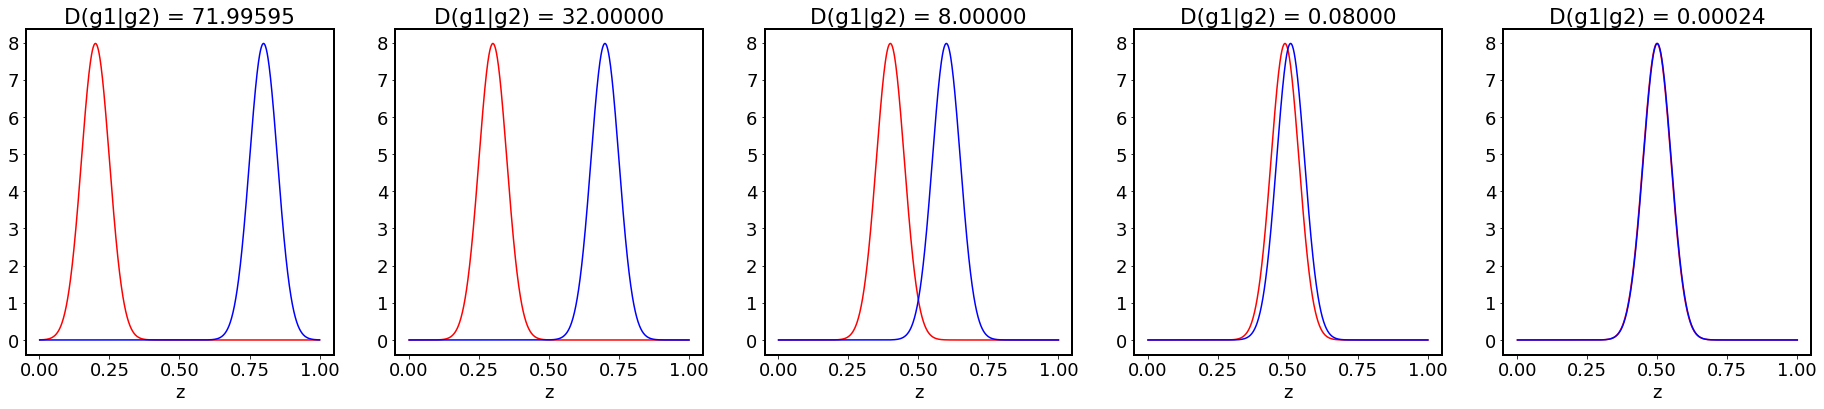

In [111]:
#definir gaussianas e calcular a kbl divergence pra elas diminuindo a distancia entre as medias
# com o objetivo de entender as ordens de grandeza envolvidas na métrica
def gaussian(mu, sigma, x):
    
    return 1/np.sqrt(2*np.pi)/sigma*np.exp(-(x-mu)**2/(2*sigma**2))


mus = [(0.2,0.8), (0.3,0.7), (0.4,0.6), (0.49,0.51), (0.499, 0.5001)]
fig = plt.figure(figsize=(32, 6))
gs = fig.add_gridspec(1, len(mus))
i=0
for mu in mus:
    ax = fig.add_subplot(gs[0, i])
    gaus1 = gaussian(mu[0], 0.05,zaxis)
    gaus2 = gaussian(mu[1], 0.05,zaxis)
    
    ax.plot(zaxis,gaus1,c='r')
    ax.plot(zaxis,gaus2,c='b')
    ax.set_xlabel('z')
    div = kbl_divergence(gaus1,gaus2,zaxis)
    ax.set_title(f'D(g1|g2) = {div:.5f}')
    # plt.show()
    i+=1

In [ ]:
My_KBL = {}
for size in latent_sizes[:]:
    if size!=40:
        name = 'size_'+str(size)
        My_KBL[name] = np.zeros(len(My_PDFs['normalized-'+name]))
        for i in range(len(My_PDFs['normalized-'+name])):
            My_KBL[name][i] = kbl_divergence(test_data['pdf'][i], My_PDFs['normalized-'+name][i],zaxis)

In [ ]:
def kbl_plots(kbl, zphot, samples=False):
    
    z_grid = 0.05
    Bins_Z   = np.arange(0, 1, z_grid)
    kbl_per_bin = []
    for bin_val in Bins_Z:
        
        between = (zphot>=bin_val)*(zphot<bin_val+z_grid)#np.where(np.logical_and(zspec>=bin_val, zspec<bin_val+z_grid))    
        kbl_bin = kbl[between]
        Photo_Z_Bin = zphot[between]
        kbl_per_bin.append(np.mean(kbl_bin))
    
    return kbl_per_bin, Bins_Z

0.09529971831301137
0.09272089127860753
0.13927038027691657


(0.0, 0.25)

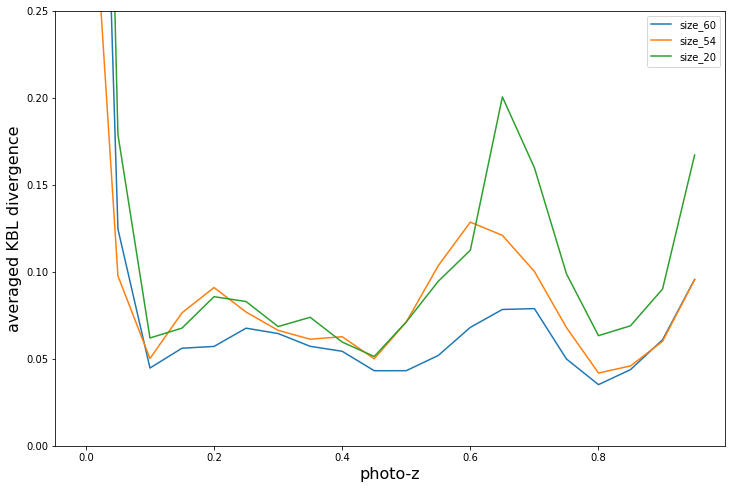

In [150]:
plt.figure(figsize=(12,8))
for size in latent_sizes[:]:
    if size!=40:
        name = 'size_'+str(size)
        kbl_per_bin, binsz = kbl_plots(My_KBL[name], My_Photoz[name])
        print(np.mean(kbl_per_bin))
        plt.plot(binsz, kbl_per_bin, label=name)
plt.ylabel("averaged KBL divergence", fontsize=16)
plt.xlabel('photo-z', fontsize=16)
plt.legend()
plt.ylim(0, 0.25)

# Photo-z point-like metrics

Metricas descritas em maiores detalhes no pdf anexo

In [167]:
def metrics_zplot(zspec, zphot, samples=False):

    def residual68(arr):
        p16=np.percentile(arr,15.85)
        p84=np.percentile(arr,84.05)
        err_68=0.5*(p84-p16)
        return err_68
    
    z_grid = 0.05
    Bins_Z   = np.arange(0, 1, z_grid)

    metrics_list = ['snmad','mean_bias', 'median_bias', 'outfrac']
    metrics = {}
    for m in metrics_list:
        metrics[m] = []

    for bin_val in Bins_Z:
        
        between = (zspec>=bin_val)*(zspec<bin_val+z_grid)#np.where(np.logical_and(zspec>=bin_val, zspec<bin_val+z_grid))    
        Spec_Z_Bin = zspec[between]
        Photo_Z_Bin = zphot[between]

        delta = Photo_Z_Bin - Spec_Z_Bin
        
        snmad = 1.48 * np.median(np.absolute(delta - np.median(delta)) / (1+Spec_Z_Bin))

        mean_bias = np.mean(delta, axis=0)

        median_bias = np.median(delta)

        outlier_frac = np.sum(  np.abs(delta)/(1+Spec_Z_Bin) >0.15)/len(delta)
        
        metrics['snmad'].append(snmad)
        metrics['mean_bias'].append(mean_bias)
        metrics['median_bias'].append(median_bias)
        metrics['outfrac'].append(outlier_frac)
        
    return metrics, Bins_Z

def relative_error(zphot, zphot_err, samples=False):
    
    z_grid = 0.05
    Bins_Z   = np.arange(0, 1, z_grid)
    
    result_nmad = []

    i = 0
    metrics_list = ['relative_error']
    metrics = {}
    for m in metrics_list:
        metrics[m] = []

    for bin_val in Bins_Z:
        between = (zphot>=bin_val)*(zphot<bin_val+z_grid)

        PhotZ_Bin_point = zphot[between]
        errPhotoZ_Bin = zphot_err[between]
        mean_relative = np.mean(errPhotoZ_Bin/(PhotZ_Bin_point+1))
        metrics['relative_error'].append(mean_relative)
        
    return metrics, Bins_Z

In [193]:

plt.rcParams['axes.labelsize'] = 40
fig = plt.figure(figsize=(70, 12), dpi=300)
gs = fig.add_gridspec(1, 4)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])
ax4 = fig.add_subplot(gs[0, 3])
axlist = [ax1, ax2, ax3, ax4]

print('PLOTING POINT METRICS...')
i=0



metrics, BINzaxis = metrics_zplot(spec_z_test, photo_z_test)
errphot, photaxis = relative_error(photo_z_test,My_Errors['test'])
a=0
m = 0
for xn in metrics:
    if m==1 and a==0:
        ax = axlist[3]
        ax.set_ylabel('relative error')
        ax.set_xlabel('photo-z')
        ax.plot(photaxis, errphot['relative_error'], ls='-', lw=3, label='True',c=color_list[6])
        ax.tick_params(axis='both', which='major', labelsize=30)
        # ax.plot(zaxis_cdrop, err_cdrop['relative_error'], ls='-', lw=3, label='cdrop')
        m=0
        a=1
    else:
        ax = axlist[m]#fig.add_subplot(gs[0, m])
        ax.set_ylabel(xn.replace('_',' ').lower().replace('outfrac', 'out. frac.'))
        ax.set_xlabel('spec-z')
        ax.plot(BINzaxis, metrics[xn], ls='-', lw=3, label='True', c=color_list[6])
        ax.tick_params(axis='both', which='major', labelsize=30)
        # ax.set_xticks(fontsize=30)
        # ax.plot(zaxis, metrics_cdrop[xn], ls='-', lw=3, label='cdrop')
    #     plt.fill_between(zaxis, np.array(metrics[xn])-np.array(metrics[xn+'_err']),
    #                      np.array(metrics[xn])+np.array(metrics[xn+'_err']), alpha=0.5)
        if not 'nmad' in xn:
            ax.axhline(0, ls='--')
    # ax.axhline(np.median(metrics[xn]), ls='--', color='red')
#     plt.xlim(0, 0.7)
    if 'nmad' in xn:
        ax.set_ylabel('$\sigma_{NMAD}$')
    # if 'median' in xn:
    #     ax.set_ylim(-0.04, 0.02)
    m+=1








for size in latent_sizes:
    name = 'size_'+str(size)
    
    if size!=40:
        metrics, BINzaxis = metrics_zplot(spec_z_test, My_Photoz[name])
        errphot, photaxis = relative_error(My_Photoz[name],My_Errors[name])
        a=0
        m = 0
        for xn in metrics:
            if m==1 and a==0:
                ax = axlist[3]
                ax.set_ylabel('relative error')
                ax.set_xlabel('photo-z')
                ax.plot(photaxis, errphot['relative_error'], ls='-', lw=3, label=name,c=color_list[i])
                ax.tick_params(axis='both', which='major', labelsize=30)
                # ax.plot(zaxis_cdrop, err_cdrop['relative_error'], ls='-', lw=3, label='cdrop')
                m=0
                a=1
            else:
                ax = axlist[m]#fig.add_subplot(gs[0, m])
                ax.set_ylabel(xn.replace('_',' ').lower().replace('outfrac', 'out. frac.'))
                ax.set_xlabel('spec-z')
                ax.plot(BINzaxis, metrics[xn], ls='-', lw=3, label=name, c=color_list[i])
                ax.tick_params(axis='both', which='major', labelsize=30)
                # ax.set_xticks(fontsize=30)
                # ax.plot(zaxis, metrics_cdrop[xn], ls='-', lw=3, label='cdrop')
            #     plt.fill_between(zaxis, np.array(metrics[xn])-np.array(metrics[xn+'_err']),
            #                      np.array(metrics[xn])+np.array(metrics[xn+'_err']), alpha=0.5)
                if not 'nmad' in xn:
                    ax.axhline(0, ls='--')
            # ax.axhline(np.median(metrics[xn]), ls='--', color='red')
        #     plt.xlim(0, 0.7)
            if 'nmad' in xn:
                ax.set_ylabel('$\sigma_{NMAD}$')
            # if 'median' in xn:
            #     ax.set_ylim(-0.04, 0.02)
            m+=1


            # plt.yticks(fontsize=30)
            # plt.xticks(fontsize=30)

        i+=1
    
ax1.legend(loc='upper left', fontsize=40)
plt.show()

PLOTING POINT METRICS...


# Photo-z PDF Metrics

PLOTING PDF METRICS...
vai calcular PIT
vai calcular odds
vai plotar
Plot will be saved in current directory as PIT_ODDS_QQ_Hexbin.pdf
vai calcular PIT
vai calcular odds
vai plotar
Plot will be saved in current directory as PIT_ODDS_QQ_Hexbin.pdf
vai calcular PIT
vai calcular odds
vai plotar
Plot will be saved in current directory as PIT_ODDS_QQ_Hexbin.pdf
vai calcular PIT
vai calcular odds
vai plotar
Plot will be saved in current directory as PIT_ODDS_QQ_Hexbin.pdf


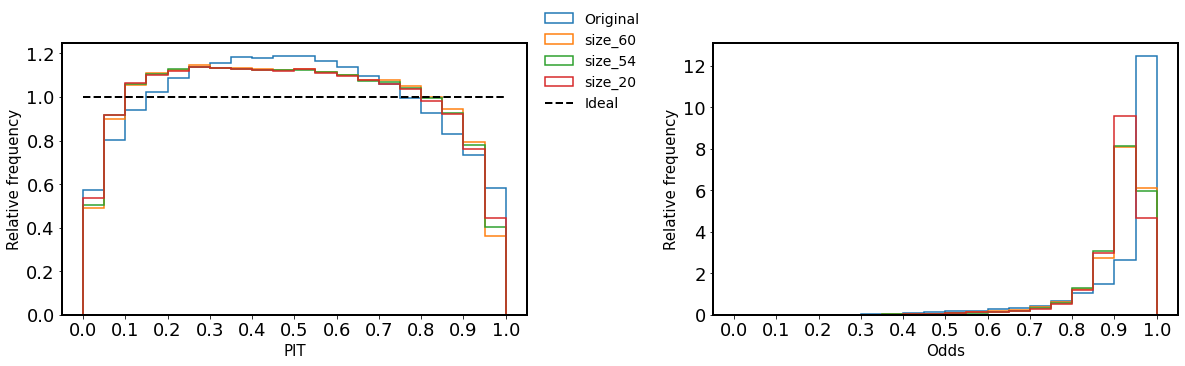

In [199]:
def Calc_and_Plot_PIT_Odds_QQ_Hexbin(Spec_Z, Photo_Z, PDF_List, z_axis=np.linspace(0.001, 1, 2000), out_dir='', ax1=None, ax2=None, fig=None, label='MDN'):
    """
    Function to calculate relevant metrics to benchmark probability distribution functions
    
    PIT: Probability integral transform. Offers a benchmark of the calibration of the PDFs, 
    where the ideal case (with perfectly calibrated PDFs) is represented by a uniform distribution.
    A U-shaped histogram indicates overly narrow PDFs. A \hat shaped histogram indicates overly
    broad PDFs. A positive slope indicates positive bias while a negative slope indicates negative
    bias.
    
    Calculated as the integral of the PDF between 0 and the spectrocopic redshift of the object.
    Source: arXiv:1608.08016

    QQ: Quantile-Quantile plot. This is a benchmark to verify how well the photometric redshifts
    are representing the spectroscopic redshifts distribution. In the ideal situation the Q-Q line
    should follow the diagonal passing through the origin with a slope of 1. If the Q-Q line falls
    below the 1-1 line, the estimations are overconfident. If the Q-Q line falls above the 1-1 line,
    the estimations are underconfident. Both situations indicate innacurate error estimatives.
    Source: arxiv:1601.07857

    Odds: Parameter that represents the fraction of a single PDF that is contained in a given
    interval around the peak. The interval is defined as the expected precision of photo-zs
    in the local universe (0.02) as per arXiv:1907.06315

    Parameters
    ----------
    Spec_Z:   numpy.ndarray containing the spectroscopic redshifts of the sample. 
              Shape (N,), where N is the number of samples.
              
    Photo_Z:  numpy.ndarray containing the photometric redshifts of the sample. 
              Shape (N,)
              
    PDF_List: numpy.ndarray containing the PDFs of each object in the sample. 
              Shape (N, M), where M is the number of points in the PDF.

    Example
    ----------
    Calc_and_Plot_PIT_Odds_QQ_Hexbin(Target['Test', 'aper_6'], PhotoZ[fold][0], Final_PDFs)
    """
    
    x = z_axis
    print('vai calcular PIT')
    PIT = []
    for i in range(len(Spec_Z)):
#         print(i)
        X_Interval = x[np.where(x < Spec_Z[i])]
        Y_Interval = PDF_List[i][np.where(x < Spec_Z[i])]
        PIT.append(np.trapz(Y_Interval, X_Interval))
        
    QQs = []
    for i in np.arange(0, 1.01, 0.01):
        QQs.append(np.quantile(PIT, i))
    print('vai calcular odds')
    x_s = pd.Series(x)
    Odds = []
    for i in range(len(Spec_Z)):
        # if i%1000==0:
        #     print(i)
        Peak_Z_Odd = x[PDF_List[i].argmax()]#x[np.where(PDF_List[i] == np.max(PDF_List[i]))][0]
        # print(Peak_Z_Odd)
        X_Interval = x[ (x>=Peak_Z_Odd-0.06)*(x<=Peak_Z_Odd+0.06) ]#x[np.where(x_s.between(Peak_Z_Odd-0.06, Peak_Z_Odd+0.06, inclusive=True))]
        # print(X_Interval)
        Y_Interval =PDF_List[i][(x>=Peak_Z_Odd-0.06)*(x<=Peak_Z_Odd+0.06)] #PDF_List[i][np.where(x_s.between(Peak_Z_Odd-0.06, Peak_Z_Odd+0.06, inclusive=True))]
        # print(Y_Interval)
        Odds.append(np.trapz(Y_Interval, X_Interval))
    
    print('vai plotar')
    
    import matplotlib.gridspec as gridspec

    if fig==None:
        fig = plt.figure(figsize=(20,10))
        plt.subplots_adjust(wspace=0.4, hspace=.3)
        gs = gridspec.GridSpec(ncols=4, nrows=2, figure=fig)
    
    if ax1==None:
        ax_PIT = fig.add_subplot(gs[0, 0:2])
    else:
        ax_PIT = ax1
    ax_PIT.hist(PIT, bins=20, range=(0,1), density=True, histtype='step', lw=1.5, label=label)
    ax_PIT.set_ylabel('Relative frequency', fontsize=15)
    ax_PIT.set_xlabel('PIT', fontsize=15)
    ax_PIT.set_xticks(np.arange(0, 1.1, 0.1))
    # ax_PIT.plot([0,1], [1,1], '--', color='black', lw=2, label='Ideal')
    # ax_PIT.legend()

    if ax2==None:
        ax_ODDS = fig.add_subplot(gs[1, 0:2])
    else:
        ax_ODDS = ax2
    ax_ODDS.hist(Odds, bins=20, range=(0,1), density=True, histtype='step', lw=1.5)
    ax_ODDS.set_ylabel('Relative frequency', fontsize=15)
    ax_ODDS.set_xlabel('Odds', fontsize=15)
    ax_ODDS.set_xticks(np.arange(0, 1.1, 0.1))
    #ax_ODDS.legend()

    # ax_QQ = fig.add_subplot(gs[0:2, 2:4])
    # ax_QQ.plot([0,1], [0,1], '--', color='black', lw=2, label='Ideal')
    # ax_QQ.plot(np.arange(0, 1.01, 0.01), QQs, lw=4)
    # ax_QQ.set_ylabel('Q$_{model}$', fontsize=15)
    # ax_QQ.set_xlabel('Q$_{theory}$', fontsize=15)
    # ax_QQ.legend()

    # ax_HEXB = fig.add_subplot(gs[0:2, 4:6])
    # ax_HEXB.plot([0, np.max(x)], [0, np.max(x)], '--', color='red', lw=2, label='x=y')
    # im = ax_HEXB.hexbin(Spec_Z, Photo_Z, gridsize=(100), bins='log', mincnt=1, cmap='viridis', extent=(0, np.max(x), 0, np.max(x)))
    # ax_HEXB.set_ylabel('Photometric redshift', fontsize=15)
    # ax_HEXB.set_xlabel('Spectroscopic redshift', fontsize=15)
    # ax_HEXB.fill_between(x=x, y1=x+0.15*(1+x), y2=3, color='red', alpha=0.10, label='Outlier region')
    # ax_HEXB.fill_between(x=x, y1=x-0.15*(1+x), y2=0, color='red', alpha=0.10)
    # ax_HEXB.set_xlim(0, np.max(x))
    # ax_HEXB.set_ylim(0, np.max(x))
    # ax_HEXB.legend()
    # cbar = plt.colorbar(im)
    # cbar.ax.set_ylabel('Number of objects', fontsize=15)

    fig.align_ylabels([ax_PIT, ax_ODDS])
    print('Plot will be saved in current directory as PIT_ODDS_QQ_Hexbin.pdf')
    # plt.savefig(out_dir+'PIT_ODDS_QQ_Hexbin.pdf', bbox_inches='tight')
    # plt.show()
    return ax_PIT,ax_ODDS




def sammple_metrics_plot(Spec_Z, Photo_Z, samples, ax1=None, ax2=None, fig=None, label='Ensemble'):#, z_axis=np.linspace(0.001, 1, 2000), out_dir=''):
  
    
    # x = z_axis
    print('vai calcular PIT')
    PIT = []
    for i in range(len(Spec_Z)):
#         print(i)
        # X_Interval = x[np.where(x < Spec_Z[i])]
        # Y_Interval = PDF_List[i][np.where(x < Spec_Z[i])]
        pit_sample = sum(samples[i]<Spec_Z[i])/len(samples[i])
        PIT.append(pit_sample)
        
    QQs = []
    for i in np.arange(0, 1.01, 0.01):
        QQs.append(np.quantile(PIT, i))
    print('vai calcular odds')
    # x_s = pd.Series(x)
    Odds = []
    for i in range(len(Spec_Z)):
        # if i%1000==0:
        #     print(i)
        Peak_Z_Odd = np.median(samples[i])#x[PDF_List[i].argmax()]#x[np.where(PDF_List[i] == np.max(PDF_List[i]))][0]
        # print(Peak_Z_Odd)
        # X_Interval = x[ (x>=Peak_Z_Odd-0.06)*(x<=Peak_Z_Odd+0.06) ]#x[np.where(x_s.between(Peak_Z_Odd-0.06, Peak_Z_Odd+0.06, inclusive=True))]
        # print(X_Interval)
        # Y_Interval =PDF_List[i][(x>=Peak_Z_Odd-0.06)*(x<=Peak_Z_Odd+0.06)] #PDF_List[i][np.where(x_s.between(Peak_Z_Odd-0.06, Peak_Z_Odd+0.06, inclusive=True))]
        # print(Y_Interval)
        odds_sample = sum((samples[i]>=Peak_Z_Odd-0.06)*(samples[i]<=Peak_Z_Odd+0.06))/len(samples[i])
        Odds.append(odds_sample)
    
    print('vai plotar')
    
    import matplotlib.gridspec as gridspec

    if fig==None:
        fig = plt.figure(figsize=(20,10))
        plt.subplots_adjust(wspace=0.4, hspace=.3)
        gs = gridspec.GridSpec(ncols=4, nrows=2, figure=fig)
    
    if ax1==None:
        ax_PIT = fig.add_subplot(gs[0, 0:2])
    else:
        ax_PIT = ax1
    ax_PIT.hist(PIT, bins=20, range=(0,1), density=True, histtype='step', lw=2.5, label=label)
    ax_PIT.set_ylabel('Relative frequency', fontsize=15)
    ax_PIT.set_xlabel('PIT', fontsize=15)
    ax_PIT.set_xticks(np.arange(0, 1.1, 0.1))
    # ax_PIT.plot([0,1], [1,1], '--', color='black', lw=2, label='Ideal')
    # ax_PIT.legend()

    if ax2==None:
        ax_ODDS = fig.add_subplot(gs[1, 0:2])
    else:
        ax_ODDS = ax2
    ax_ODDS.hist(Odds, bins=20, range=(0,1), density=True, histtype='step', lw=2.5)
    ax_ODDS.set_ylabel('Relative frequency', fontsize=15)
    ax_ODDS.set_xlabel('Odds', fontsize=15)
    ax_ODDS.set_xticks(np.arange(0, 1.1, 0.1))
    #ax_ODDS.legend()

    # ax_QQ = fig.add_subplot(gs[0:2, 2:4])
    # ax_QQ.plot([0,1], [0,1], '--', color='black', lw=2, label='Ideal')
    # ax_QQ.plot(np.arange(0, 1.01, 0.01), QQs, lw=4)
    # ax_QQ.set_ylabel('Q$_{model}$', fontsize=15)
    # ax_QQ.set_xlabel('Q$_{theory}$', fontsize=15)
    # ax_QQ.legend()

    # ax_HEXB = fig.add_subplot(gs[0:2, 4:6])
    # ax_HEXB.plot([0, np.max(x)], [0, np.max(x)], '--', color='red', lw=2, label='x=y')
    # im = ax_HEXB.hexbin(Spec_Z, Photo_Z, gridsize=(100), bins='log', mincnt=1, cmap='viridis', extent=(0, np.max(x), 0, np.max(x)))
    # ax_HEXB.set_ylabel('Photometric redshift', fontsize=15)
    # ax_HEXB.set_xlabel('Spectroscopic redshift', fontsize=15)
    # ax_HEXB.fill_between(x=x, y1=x+0.15*(1+x), y2=3, color='red', alpha=0.10, label='Outlier region')
    # ax_HEXB.fill_between(x=x, y1=x-0.15*(1+x), y2=0, color='red', alpha=0.10)
    # ax_HEXB.set_xlim(0, np.max(x))
    # ax_HEXB.set_ylim(0, np.max(x))
    # ax_HEXB.legend()
    # cbar = plt.colorbar(im)
    # cbar.ax.set_ylabel('Number of objects', fontsize=15)

    fig.align_ylabels([ax_PIT, ax_ODDS])
    print('Plot will be saved in current directory as PIT_ODDS_QQ_Hexbin.pdf')
    # plt.savefig(out_dir+'PIT_ODDS_QQ_Hexbin.pdf', bbox_inches='tight')
    # plt.show()
    return ax_PIT,ax_ODDS

# no_outlier = np.abs(to_compare_cdrop[:,0] - specz)/(1+specz) < 0.15

z_axis = np.linspace(0.001, 1, 1000)
# PDFs_predict = My_PDFs
# # pdf_exists = np.mean(PDFs_predict,axis=1)>0
# normalized_pdfs = PDFs_predict/np.vstack([np.trapz(PDFs_predict, z_axis, axis=1)]*PDFs_predict.shape[1]).T
print('PLOTING PDF METRICS...')
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(20,5))
plt.subplots_adjust(wspace=0.4, hspace=.3)
gs = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

ax_PIT = fig.add_subplot(gs[0, 0])
ax_ODDS = fig.add_subplot(gs[0, 1])

ax_PIT, ax_ODDS =Calc_and_Plot_PIT_Odds_QQ_Hexbin(spec_z_test, photo_z_test,
                                         normalized_x_test, z_axis, ax1=ax_PIT, ax2=ax_ODDS, fig=fig, label='Original')

for size in latent_sizes:
    name = 'size_'+str(size)
    if size!=40:
        ax_PIT, ax_ODDS =Calc_and_Plot_PIT_Odds_QQ_Hexbin(spec_z_test, My_Photoz[name],
                                         My_PDFs['normalized-'+name], z_axis, ax1=ax_PIT, ax2=ax_ODDS, fig=fig, label=name)#, out_dir=output_dir)


# ax_PIT, ax_ODDS =PIT, Odds = sammple_metrics_plot(specz[no_outlier], to_compare_cdrop[:,0][no_outlier], cdrop_samples[no_outlier],
#                                                   ax1=ax_PIT, ax2=ax_ODDS, fig=fig)

ax_PIT.plot([0,1], [1,1], '--', color='black', lw=2, label='Ideal')
handles, labels = ax_PIT.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center',  frameon=False, fontsize=14)
plt.show()

# Train with PDF components

Agora queremos codificar e decodificar os componentes que geram as PDFs


## Load Data 

Carrega os componentes $\alpha_n$, $\mu_n$, $\sigma_n$ geradores das pdfs 

Lembrando que estas são definidas por

$$
PDF(z) = \sum_{n=1}^N\alpha_n\times gaussian(\mu_n,\sigma_n)
$$

No nosso caso utilizamos N=18

In [ ]:
train_data['components'] = np.load(data_dir + 'dataset_'+dataset_name+'components_pdfs_TRAIN.npy')

test_data['components'] = np.load(data_dir + 'dataset_'+dataset_name+'components_pdfs.npy')

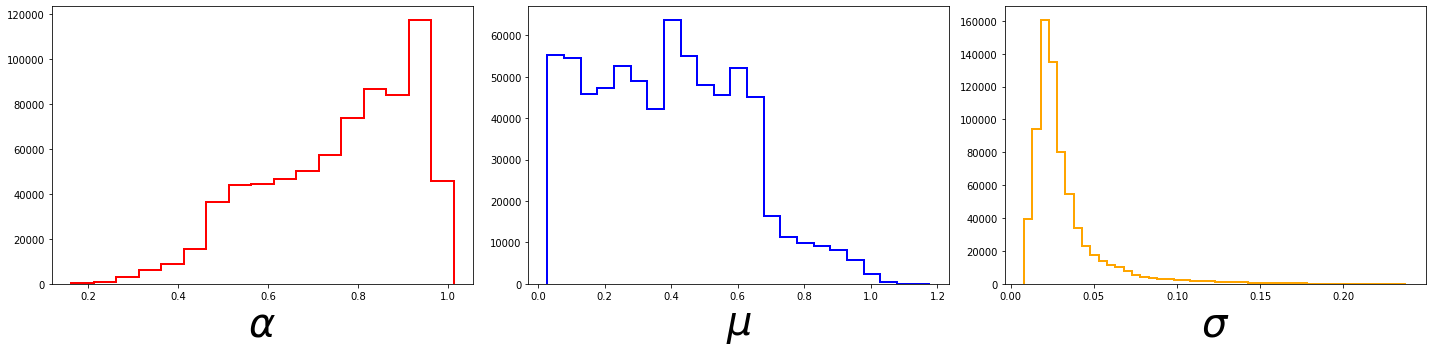

In [153]:
# Visualizando os dados:
# histograma do alpha máximo (a ideia é que represente a gaussiana "mais relevante")
# histograma das média ponderada em alpha para os valores de mu e sigma


fig = plt.figure(figsize=(20,5))
# plt.subplots_adjust(wspace=0.4, hspace=.3)
gs = plt.GridSpec(ncols=3, nrows=1, figure=fig)

alpha_ax = fig.add_subplot(gs[0, 0])
mu_ax = fig.add_subplot(gs[0, 1])
sigma_ax = fig.add_subplot(gs[0, 2])


mu_bin = 0.05


# mumax_idxs = np.vstack([np.arange(0,18,1)]*len(train_data['components'][:,:,0]) )/np.argmax(train_data['components'][:,:,0], axis=1).reshape(-1,1) ==1

mu_maxs = np.sum(train_data['components'][:,:,1]*train_data['components'][:,:,0], axis=1)
mu_arange = binarange(mu_maxs, binsize=mu_bin)
mu_ax.hist(mu_maxs, bins=mu_arange, density=False, histtype='step', color='blue', lw=2)
# mu_ax.hist(test_data['components'][:,:,2], density=True, histtype='step')

sigma_bin = 0.005
sigma_maxs = np.sum(train_data['components'][:,:,2]*train_data['components'][:,:,0], axis=1)
sigma_arange = binarange(sigma_maxs, binsize=sigma_bin)
sigma_ax.hist(sigma_maxs, bins=sigma_arange, density=False, histtype='step', color='orange', lw=2)

alpha_bin = 0.05
alpha_maxs = np.max(train_data['components'][:,:,0], axis=1)
alpha_arange = binarange(alpha_maxs, binsize=alpha_bin)
alpha_ax.hist(alpha_maxs, bins=alpha_arange, density=False, histtype='step', color='red', lw=2)

mu_ax.set_xlabel('$\mu$')
sigma_ax.set_xlabel('$\sigma$')
alpha_ax.set_xlabel(r'$\alpha$')


plt.tight_layout()

In [154]:
# Reorganizando os daddos que foram salvos com o shape (n_objects, 18, 3), para o shape (n_objects, 54)
# sendo os 3 grupos de 18 valores em sequencia correspondentes aos alphas, mus e sigmas, respectivamente.

x_components_train = np.vstack([train_data['components'][:,:,i].T for i in range(3)]).T

x_components_test = np.vstack([test_data['components'][:,:,i].T for i in range(3)]).T#train_data['components'].reshape(-1,18*3)

In [155]:
np.random.seed(42)
val_size = 0.1
val_idx = np.random.uniform(0,1,len(x_components_train)) < 0.1

x_components_val = x_components_train[val_idx]
x_components_train = x_components_train[~val_idx]

## BUILD MODEL

In [156]:

# definindo função de ativação nnelu para os valores de sigma (não negativos)

def nnelu(input):
    """ Computes the Non-Negative Exponential Linear Unit
    """
    return tf.add(tf.constant(1, dtype=tf.float32), tf.nn.elu(input))
    
tf.keras.utils.get_custom_objects().update({'nnelu': tf.keras.layers.Activation(nnelu)})


feature_size = 20
n_components = 18

input_dim = train_data['components'][:,:,0].shape[1:]


input_alpha = tf.keras.layers.Input(input_dim)
h1_alpha = tf.keras.layers.Dense(units=16, activation='linear')(input_alpha)

input_mu = tf.keras.layers.Input(input_dim)
h1_mu = tf.keras.layers.Dense(units=16, activation='linear')(input_mu)

input_sigma = tf.keras.layers.Input(input_dim)
h1_sigma = tf.keras.layers.Dense(units=16, activation='linear')(input_sigma)

concat_layer = tf.keras.layers.Concatenate()([h1_alpha, h1_mu, h1_sigma])

latent_space = tf.keras.layers.Dense(units=feature_size, activation='linear')(concat_layer)

encoder = Model(inputs =[input_alpha,input_mu,input_sigma], outputs = latent_space)


h2_alpha = tf.keras.layers.Dense(units=16, activation='linear')(encoder.output)
output_alpha = tf.keras.layers.Dense(units=n_components, activation='softmax')(h2_alpha)

h2_mu = tf.keras.layers.Dense(units=16, activation='linear')(encoder.output)
output_mu = tf.keras.layers.Dense(units=n_components, activation='linear')(h2_mu)

h2_sigma = tf.keras.layers.Dense(units=16, activation='linear')(encoder.output)
output_sigma = tf.keras.layers.Dense(units=n_components, activation='nnelu')(h2_sigma)

output_layer =  tf.keras.layers.Concatenate()([output_alpha, output_mu, output_sigma])

decoder = Model(inputs =latent_space, outputs = output_layer)


autoencoder = Model(inputs=encoder.input, outputs=decoder(encoder.output))
autoencoder.compile(loss='mse', optimizer='Nadam')
autoencoder.summary()
# input_alpha = Sequential([
#     Dense(32, activation='linear', input_shape=(input_dim,)),
#     # Dense(256, activation='linear'),
# #     Dense(50, activation='linear'),
#     # Dense(feature_size, activation='linear')
# #     Dense(latent_dim, activation='relu', input_shape=(input_dim,))
# ])

# input_mu = Sequential([
#     Dense(32, activation='linear', input_shape=(input_dim,)),
#     # Dense(256, activation='linear'),
# #     Dense(50, activation='linear'),
#     # Dense(feature_size, activation='linear')
# #     Dense(latent_dim, activation='relu', input_shape=(input_dim,))
# ])

# input_sigma = Sequential([
#     Dense(32, activation='linear', input_shape=(input_dim,)),
#     # Dense(256, activation='linear'),
# #     Dense(50, activation='linear'),
#     # Dense(feature_size, activation='linear')
# #     Dense(latent_dim, activation='relu', input_shape=(input_dim,))
# ])

# latent_concat = 

# decoder = Sequential([
#     Dense(256, activation='linear', input_shape=(feature_size,)),
#     Dense(512, activation='linear'),
# #     Dense(50, activation ='linear'),
#     Dense(input_dim[0], activation='softmax')
# #     Dense(input_dim, activation='relu', input_shape=(latent_dim,))
# ])

# autoencoder = Model(inputs=encoder.input, outputs=decoder(encoder.output))
# autoencoder.compile(loss='mse', optimizer='Nadam')

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 18)]         0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None, 18)]         0           []                               
                                                                                                  
 input_11 (InputLayer)          [(None, 18)]         0           []                               
                                                                                                  
 dense_44 (Dense)               (None, 16)           304         ['input_9[0][0]']                
                                                                                           

## Training

In [157]:
name = f'PDF_COMPONENTS_{feature_size}'
checkpoint_filepath = f'/tf/dados10T/gabriel/astroinfo/my_best_model_{name}.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
filepath=checkpoint_filepath,
# save_weights_only=True,
monitor='val_loss',
mode='min',
save_best_only=True)

history = autoencoder.fit(x=[x_components_train[:,:18], x_components_train[:,18:18*2], x_components_train[:,18*2:18*3]],
                        y=x_components_train,
                        validation_data=([x_components_val[:,:18], x_components_val[:,18:18*2], x_components_val[:,18*2:18*3]],
                                        x_components_val),
                        batch_size=256,
                        epochs=30,
                        callbacks=[checkpoint])

Epoch 1/30
2532/2532 [==============================] - 26s 10ms/step - loss: 0.0067 - val_loss: 6.4033e-04
Epoch 2/30
2532/2532 [==============================] - 25s 10ms/step - loss: 4.0055e-04 - val_loss: 2.4640e-04
Epoch 3/30
2532/2532 [==============================] - 25s 10ms/step - loss: 2.0022e-04 - val_loss: 1.5218e-04
Epoch 4/30
2532/2532 [==============================] - 24s 10ms/step - loss: 1.3056e-04 - val_loss: 1.0581e-04
Epoch 5/30
2532/2532 [==============================] - 24s 10ms/step - loss: 9.5678e-05 - val_loss: 8.9804e-05
Epoch 6/30
2532/2532 [==============================] - 24s 9ms/step - loss: 7.5286e-05 - val_loss: 6.6368e-05
Epoch 7/30
2532/2532 [==============================] - 24s 9ms/step - loss: 6.2547e-05 - val_loss: 5.5211e-05
Epoch 8/30
2532/2532 [==============================] - 25s 10ms/step - loss: 5.3954e-05 - val_loss: 5.8456e-05
Epoch 9/30
2532/2532 [==============================] - 25s 10ms/step - loss: 4.8052e-05 - val_loss: 4.7472e-0

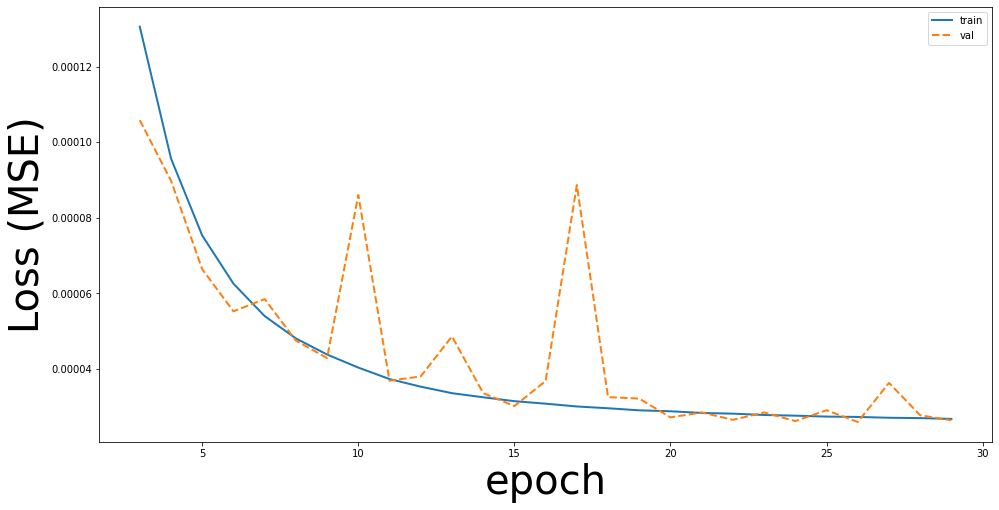

In [158]:
# Curva de treinamento

fig = plt.figure(figsize=(16, 8))
color_list = list(mpl.colors.TABLEAU_COLORS)


initial_epoch = 3
epochs = range(len(history.history['loss']))
plt.plot(epochs[initial_epoch:], history.history['loss'][initial_epoch:], c=color_list[0], ls='-', lw=2, label='train')
plt.plot(epochs[initial_epoch:], history.history['val_loss'][initial_epoch:], c=color_list[1], ls='--', lw=2, label='val')

    
plt.xlabel('epoch')
plt.ylabel('Loss (MSE)')
plt.legend()

## Inferences

In [159]:
# realizando inferencia para o conjunto de teste
latent_components = encoder.predict([x_components_test[:,:18], x_components_test[:,18:18*2], x_components_test[:,18*2:18*3]])

reconstructed_components = decoder.predict(latent_components)

15738/15738 [==============================] - 20s 1ms/step


In [160]:
#decodificando as predições

alpha_pred = reconstructed_components[:,:18] 
mu_pred = reconstructed_components[:,18:18*2] 
sigma_pred = reconstructed_components[:,18*2:18*3] 

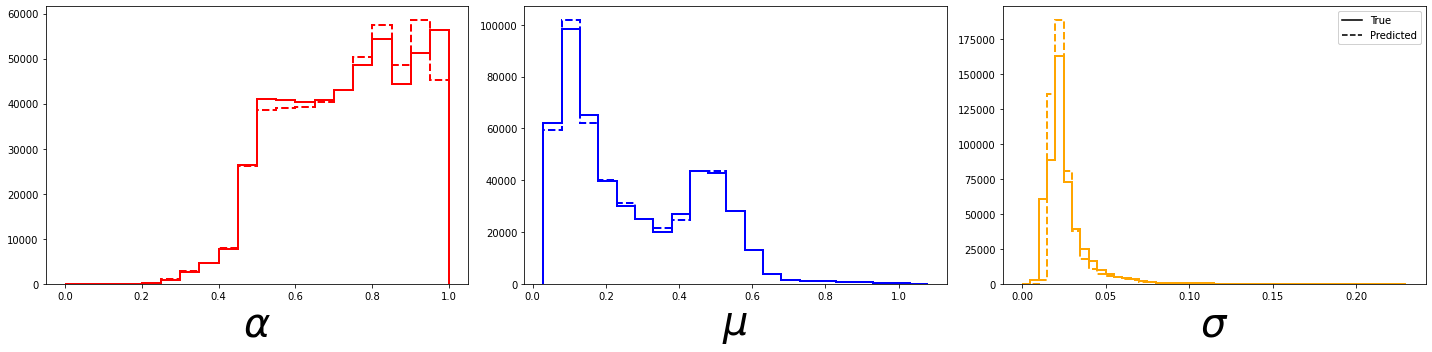

In [163]:
# Comparando os histogramas anteriores pro conjunto de teste

fig = plt.figure(figsize=(20,5))
# plt.subplots_adjust(wspace=0.4, hspace=.3)
gs = plt.GridSpec(ncols=3, nrows=1, figure=fig)

alpha_ax = fig.add_subplot(gs[0, 0])
mu_ax = fig.add_subplot(gs[0, 1])
sigma_ax = fig.add_subplot(gs[0, 2])


mu_bin = 0.05


# mumax_idxs = np.vstack([np.arange(0,18,1)]*len(train_data['components'][:,:,0]) )/np.argmax(train_data['components'][:,:,0], axis=1).reshape(-1,1) ==1

mu_maxs = np.sum(test_data['components'][:,:,1]*test_data['components'][:,:,0], axis=1)
mu_arange = binarange(mu_maxs, binsize=mu_bin)
mu_ax.hist(mu_maxs, bins=mu_arange, density=False, histtype='step', color='blue', lw=2)
# mu_ax.hist(test_data['components'][:,:,2], density=True, histtype='step')

sigma_bin = 0.005
sigma_maxs = np.sum(test_data['components'][:,:,2]*test_data['components'][:,:,0], axis=1)
sigma_arange = binarange(sigma_maxs, binsize=sigma_bin, minimo=0)
sigma_ax.hist(sigma_maxs, bins=sigma_arange, density=False, histtype='step', color='orange', lw=2)

alpha_bin = 0.05
alpha_maxs = np.max(test_data['components'][:,:,0], axis=1)
alpha_arange = binarange(alpha_maxs, binsize=alpha_bin, minimo=0)
alpha_ax.hist(alpha_maxs, bins=alpha_arange, density=False, histtype='step', color='red', lw=2)

mu_ax.set_xlabel('$\mu$')
sigma_ax.set_xlabel('$\sigma$')
alpha_ax.set_xlabel(r'$\alpha$')




mu_maxs = np.sum(mu_pred*alpha_pred, axis=1)
# mu_arange = binarange(mu_maxs, binsize=mu_bin)
mu_ax.hist(mu_maxs, bins=mu_arange, density=False, histtype='step', color='blue', lw=2, ls='--')
# mu_ax.hist(test_data['components'][:,:,2], density=True, histtype='step')

sigma_bin = 0.005
sigma_maxs = np.sum(sigma_pred*alpha_pred, axis=1)
# sigma_arange = binarange(sigma_maxs, binsize=sigma_bin, minimo=0)
sigma_ax.hist(sigma_maxs, bins=sigma_arange, density=False, histtype='step', color='orange', lw=2, ls='--')

alpha_bin = 0.05
alpha_maxs = np.max(alpha_pred, axis=1)
# alpha_arange = binarange(alpha_maxs, binsize=alpha_bin, minimo=0)
alpha_ax.hist(alpha_maxs, bins=alpha_arange, density=False, histtype='step', color='red', lw=2, ls='--')



solid = plt.Line2D([0,1],[0,1],linestyle='-', color='black')
dashed = plt.Line2D([0,1],[0,1],linestyle='--', color='black')


lineslegends = plt.legend([solid,dashed], ['True', 'Predicted'], loc='best')
plt.gca().add_artist(lineslegends)



plt.tight_layout()

## Rescontructing PDFs

a reconstrução é feita a partir da biblioteca tensorflow_probability, seguindo a definição das PDFs

In [164]:
from tensorflow_probability import distributions as tfd

In [165]:
My_PDFs = {}
My_Peaks = {}

### True PDFs

In [167]:
zaxis = np.linspace(0.001, 2, 1000)
My_PDFs['true'] = np.zeros( (len(x_components_test), len(zaxis)) )
PDFs_predict = []

for i in range(len(x_components_test)):
    gm_preds = tfd.MixtureSameFamily(
            mixture_distribution=tfd.Categorical(probs=x_components_test[:,:18][i]),
            components_distribution=tfd.Normal(
                loc= x_components_test[:,18:18*2][i],       
                scale=x_components_test[:,18*2:18*3][i]))
    My_PDFs['true'][i] = np.array(gm_preds.prob(zaxis))
    
My_Peaks['true'] = zaxis[My_PDFs['true'].argmax(axis=1)]
np.save(data_dir+'astroinfo_normalized_pdfs_TRUE_zaxis0to2.npy', My_PDFs['true'])

### Pred PDFs

In [168]:
zaxis = np.linspace(0.001, 2, 1000)
My_PDFs['pred'] = np.zeros( (len(x_components_test), len(zaxis)) )
PDFs_predict = []

for i in range(len(x_components_test)):
    gm_preds = tfd.MixtureSameFamily(
            mixture_distribution=tfd.Categorical(probs=alpha_pred[i]),
            components_distribution=tfd.Normal(
                loc=mu_pred[i],       
                scale=sigma_pred[i]))
    My_PDFs['pred'][i] = np.array(gm_preds.prob(zaxis))
    
My_Peaks['pred'] = zaxis[My_PDFs['pred'].argmax(axis=1)]

In [51]:
# normalized_pdfs_pred = My_PDFs['pred']/np.trapz(My_PDFs['pred'], zaxis, axis=1).reshape(-1,1)
np.save(data_dir+'astroinfo_normalized_pdfs_PRED_zaxis0to2.npy', My_PDFs['pred'])

112140
138229
53403
46105
66032
73922
8436
2636
1565
691


Text(0, 0.5, 'Mean PDF')

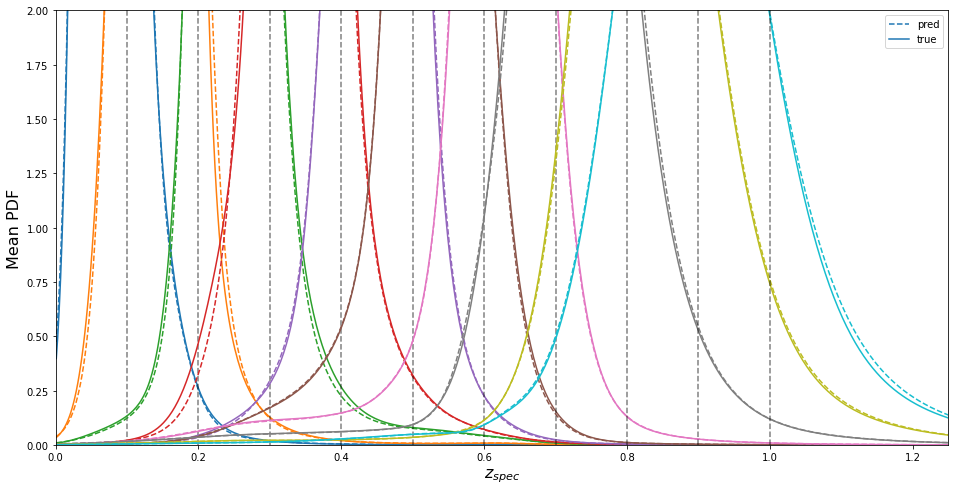

In [170]:
fig = plt.figure(figsize=(16,8))
zstep = 0.1
zaxis = np.linspace(0.001, 2, 1000)
i=0
line_list = ['--', '-.', ':']

for z in np.arange(0,1,zstep):
    inrange_train = test_metadata['z_spec'].between(z, z+0.1)
    print(sum(inrange_train))
    test_pdfs_bin =  My_PDFs['true'][np.array(inrange_train)]
    # l=0
    # for size in latent_sizes[:]:
    #     if size!=40:
            # name = 'size_'+str(size)

    predict_pdfs_bin =  My_PDFs['pred'][np.array(inrange_train)]
    plt.plot(zaxis,np.mean(predict_pdfs_bin, axis=0), ls='--', c=color_list[i], label='pred')
    # # l+=1
    plt.plot(zaxis,np.mean(test_pdfs_bin, axis=0), c = color_list[i], label='true')
    plt.axvline(z+zstep, ls='--', alpha=0.5, c='k')
    
    if i==0:
        plt.legend()
    
    i+=1
plt.xlim(0,1.25)
plt.ylim(0,2)
plt.xlabel('$z_{spec}$', fontsize=16)
plt.ylabel('Mean PDF', fontsize=16)

## Point-like metrics

In [84]:

My_Errors = {}


In [171]:
#Calculating the Errors

def pdf_s68(pdf, interval, z_axis):
    areas = pdf*interval
    p16=0
    p84=0
    
    p16_lock = 0
    p84_lock = 0
    for i in range(len(areas)):
        
        
        p16+=areas[i]
        if p16>=15.85/100 and p16_lock==0:
            p16_final = z_axis[i]
            p16_lock = 1
            
        p84+=areas[-(1+i)]
        if p84>=(100-84.05)/100 and p84_lock==0:
            p84_final = z_axis[len(areas) - (i+1)]
            p84_lock = 1
       
        if p84_lock*p16_lock:
            break
    s68 = 0.5*(p84_final-p16_final)
    return s68


for name in ['true', 'pred']:
    
    My_Errors[name] = np.zeros(len(My_PDFs[name]))
    for i in range(len(My_PDFs[name])):
        My_Errors[name][i] =  pdf_s68(My_PDFs[name][i], interval = zaxis[2]-zaxis[1], z_axis=zaxis)
spec_z_test = np.array(test_metadata['z_spec'])

In [172]:
def metrics_zplot(zspec, zphot, samples=False):

    def residual68(arr):
        p16=np.percentile(arr,15.85)
        p84=np.percentile(arr,84.05)
        err_68=0.5*(p84-p16)
        return err_68
    
    z_grid = 0.05
    Bins_Z   = np.arange(0, 1, z_grid)

    metrics_list = ['snmad','mean_bias', 'median_bias', 'outfrac']
    metrics = {}
    for m in metrics_list:
        metrics[m] = []

    for bin_val in Bins_Z:
        
        between = (zspec>=bin_val)*(zspec<bin_val+z_grid)#np.where(np.logical_and(zspec>=bin_val, zspec<bin_val+z_grid))    
        Spec_Z_Bin = zspec[between]
        Photo_Z_Bin = zphot[between]

        delta = Photo_Z_Bin - Spec_Z_Bin
        
        snmad = 1.48 * np.median(np.absolute(delta - np.median(delta)) / (1+Spec_Z_Bin))

        mean_bias = np.mean(delta, axis=0)

        median_bias = np.median(delta)

        outlier_frac = np.sum(  np.abs(delta)/(1+Spec_Z_Bin) >0.15)/len(delta)
        
        metrics['snmad'].append(snmad)
        metrics['mean_bias'].append(mean_bias)
        metrics['median_bias'].append(median_bias)
        metrics['outfrac'].append(outlier_frac)
        
    return metrics, Bins_Z

def relative_error(zphot, zphot_err, samples=False):
    
    z_grid = 0.05
    Bins_Z   = np.arange(0, 1, z_grid)
    
    result_nmad = []

    i = 0
    metrics_list = ['relative_error']
    metrics = {}
    for m in metrics_list:
        metrics[m] = []

    for bin_val in Bins_Z:
        between = (zphot>=bin_val)*(zphot<bin_val+z_grid)

        PhotZ_Bin_point = zphot[between]
        errPhotoZ_Bin = zphot_err[between]
        mean_relative = np.mean(errPhotoZ_Bin/(PhotZ_Bin_point+1))
        metrics['relative_error'].append(mean_relative)
        
    return metrics, Bins_Z

In [173]:

plt.rcParams['axes.labelsize'] = 40
fig = plt.figure(figsize=(70, 12), dpi=300)
gs = fig.add_gridspec(1, 4)

# ax1 = fig.add_subplot(gs[0, 0])
# ax2 = fig.add_subplot(gs[0, 1])
# plt.rcParams['axes.labelsize'] = 40
# fig = plt.figure(figsize=(70, 12), dpi=300)
# gs = fig.add_gridspec(1, 4)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])
ax4 = fig.add_subplot(gs[0, 3])
axlist = [ax1, ax2, ax3, ax4]

print('PLOTING POINT METRICS...')
i=0


for name in ['true', 'pred']:
#     name = 'size_'+str(size)
    
#     if size!=40:
    metrics, BINzaxis = metrics_zplot(spec_z_test, My_Peaks[name])
    errphot, photaxis = relative_error(My_Peaks[name],My_Errors[name])
    a=0
    m = 0
    for xn in metrics:
        if m==1 and a==0:
            ax = axlist[3]
            ax.set_ylabel('relative error')
            ax.set_xlabel('photo-z')
            ax.plot(photaxis, errphot['relative_error'], ls='-', lw=3, label=name,c=color_list[i])
            ax.tick_params(axis='both', which='major', labelsize=30)
            # ax.plot(zaxis_cdrop, err_cdrop['relative_error'], ls='-', lw=3, label='cdrop')
            m=0
            a=1
        else:
            ax = axlist[m]#fig.add_subplot(gs[0, m])
            ax.set_ylabel(xn.replace('_',' ').lower().replace('outfrac', 'out. frac.'))
            ax.set_xlabel('spec-z')
            ax.plot(BINzaxis, metrics[xn], ls='-', lw=3, label=name, c=color_list[i])
            ax.tick_params(axis='both', which='major', labelsize=30)
            # ax.set_xticks(fontsize=30)
            # ax.plot(zaxis, metrics_cdrop[xn], ls='-', lw=3, label='cdrop')
        #     plt.fill_between(zaxis, np.array(metrics[xn])-np.array(metrics[xn+'_err']),
        #                      np.array(metrics[xn])+np.array(metrics[xn+'_err']), alpha=0.5)
            if not 'nmad' in xn:
                ax.axhline(0, ls='--')
        # ax.axhline(np.median(metrics[xn]), ls='--', color='red')
    #     plt.xlim(0, 0.7)
        if 'nmad' in xn:
            ax.set_ylabel('$\sigma_{NMAD}$')
        # if 'median' in xn:
        #     ax.set_ylim(-0.04, 0.02)
        m+=1


        # plt.yticks(fontsize=30)
        # plt.xticks(fontsize=30)

    i+=1
    
ax1.legend(loc='upper left', fontsize=40)
plt.show()
ax3 = fig.add_subplot(gs[0, 2])
ax4 = fig.add_subplot(gs[0, 3])
axlist = [ax1, ax2, ax3, ax4]


PLOTING POINT METRICS...


## PDF metrics

PLOTING PDF METRICS...
vai calcular PIT
vai calcular odds
vai plotar
Plot will be saved in current directory as PIT_ODDS_QQ_Hexbin.pdf
vai calcular PIT
vai calcular odds
vai plotar
Plot will be saved in current directory as PIT_ODDS_QQ_Hexbin.pdf


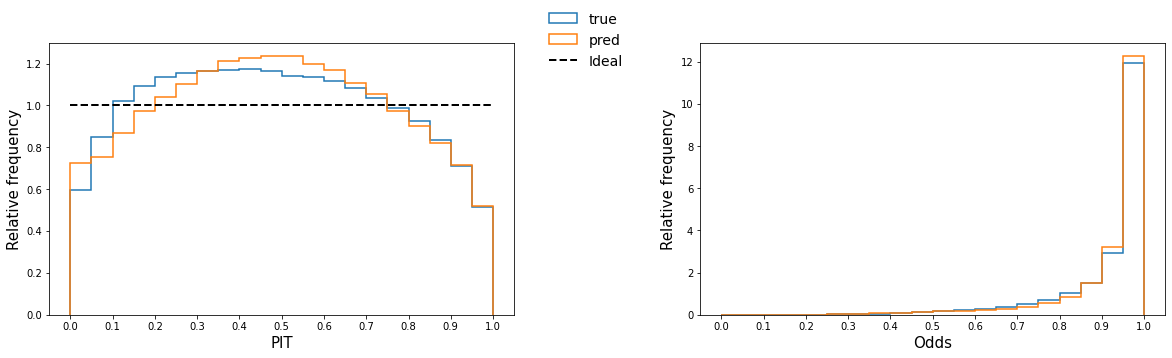

In [174]:
def Calc_and_Plot_PIT_Odds_QQ_Hexbin(Spec_Z, Photo_Z, PDF_List, z_axis=np.linspace(0.001, 1, 2000), out_dir='', ax1=None, ax2=None, fig=None, label='MDN'):
    """
    Function to calculate relevant metrics to benchmark probability distribution functions
    
    PIT: Probability integral transform. Offers a benchmark of the calibration of the PDFs, 
    where the ideal case (with perfectly calibrated PDFs) is represented by a uniform distribution.
    A U-shaped histogram indicates overly narrow PDFs. A \hat shaped histogram indicates overly
    broad PDFs. A positive slope indicates positive bias while a negative slope indicates negative
    bias.
    
    Calculated as the integral of the PDF between 0 and the spectrocopic redshift of the object.
    Source: arXiv:1608.08016

    QQ: Quantile-Quantile plot. This is a benchmark to verify how well the photometric redshifts
    are representing the spectroscopic redshifts distribution. In the ideal situation the Q-Q line
    should follow the diagonal passing through the origin with a slope of 1. If the Q-Q line falls
    below the 1-1 line, the estimations are overconfident. If the Q-Q line falls above the 1-1 line,
    the estimations are underconfident. Both situations indicate innacurate error estimatives.
    Source: arxiv:1601.07857

    Odds: Parameter that represents the fraction of a single PDF that is contained in a given
    interval around the peak. The interval is defined as the expected precision of photo-zs
    in the local universe (0.02) as per arXiv:1907.06315

    Parameters
    ----------
    Spec_Z:   numpy.ndarray containing the spectroscopic redshifts of the sample. 
              Shape (N,), where N is the number of samples.
              
    Photo_Z:  numpy.ndarray containing the photometric redshifts of the sample. 
              Shape (N,)
              
    PDF_List: numpy.ndarray containing the PDFs of each object in the sample. 
              Shape (N, M), where M is the number of points in the PDF.

    Example
    ----------
    Calc_and_Plot_PIT_Odds_QQ_Hexbin(Target['Test', 'aper_6'], PhotoZ[fold][0], Final_PDFs)
    """
    
    x = z_axis
    print('vai calcular PIT')
    PIT = []
    for i in range(len(Spec_Z)):
#         print(i)
        X_Interval = x[np.where(x < Spec_Z[i])]
        Y_Interval = PDF_List[i][np.where(x < Spec_Z[i])]
        PIT.append(np.trapz(Y_Interval, X_Interval))
        
    QQs = []
    for i in np.arange(0, 1.01, 0.01):
        QQs.append(np.quantile(PIT, i))
    print('vai calcular odds')
    x_s = pd.Series(x)
    Odds = []
    for i in range(len(Spec_Z)):
        # if i%1000==0:
        #     print(i)
        Peak_Z_Odd = x[PDF_List[i].argmax()]#x[np.where(PDF_List[i] == np.max(PDF_List[i]))][0]
        # print(Peak_Z_Odd)
        X_Interval = x[ (x>=Peak_Z_Odd-0.06)*(x<=Peak_Z_Odd+0.06) ]#x[np.where(x_s.between(Peak_Z_Odd-0.06, Peak_Z_Odd+0.06, inclusive=True))]
        # print(X_Interval)
        Y_Interval =PDF_List[i][(x>=Peak_Z_Odd-0.06)*(x<=Peak_Z_Odd+0.06)] #PDF_List[i][np.where(x_s.between(Peak_Z_Odd-0.06, Peak_Z_Odd+0.06, inclusive=True))]
        # print(Y_Interval)
        Odds.append(np.trapz(Y_Interval, X_Interval))
    
    print('vai plotar')
    
    import matplotlib.gridspec as gridspec

    if fig==None:
        fig = plt.figure(figsize=(20,10))
        plt.subplots_adjust(wspace=0.4, hspace=.3)
        gs = gridspec.GridSpec(ncols=4, nrows=2, figure=fig)
    
    if ax1==None:
        ax_PIT = fig.add_subplot(gs[0, 0:2])
    else:
        ax_PIT = ax1
    ax_PIT.hist(PIT, bins=20, range=(0,1), density=True, histtype='step', lw=1.5, label=label)
    ax_PIT.set_ylabel('Relative frequency', fontsize=15)
    ax_PIT.set_xlabel('PIT', fontsize=15)
    ax_PIT.set_xticks(np.arange(0, 1.1, 0.1))
    # ax_PIT.plot([0,1], [1,1], '--', color='black', lw=2, label='Ideal')
    # ax_PIT.legend()

    if ax2==None:
        ax_ODDS = fig.add_subplot(gs[1, 0:2])
    else:
        ax_ODDS = ax2
    ax_ODDS.hist(Odds, bins=20, range=(0,1), density=True, histtype='step', lw=1.5)
    ax_ODDS.set_ylabel('Relative frequency', fontsize=15)
    ax_ODDS.set_xlabel('Odds', fontsize=15)
    ax_ODDS.set_xticks(np.arange(0, 1.1, 0.1))
    #ax_ODDS.legend()

    # ax_QQ = fig.add_subplot(gs[0:2, 2:4])
    # ax_QQ.plot([0,1], [0,1], '--', color='black', lw=2, label='Ideal')
    # ax_QQ.plot(np.arange(0, 1.01, 0.01), QQs, lw=4)
    # ax_QQ.set_ylabel('Q$_{model}$', fontsize=15)
    # ax_QQ.set_xlabel('Q$_{theory}$', fontsize=15)
    # ax_QQ.legend()

    # ax_HEXB = fig.add_subplot(gs[0:2, 4:6])
    # ax_HEXB.plot([0, np.max(x)], [0, np.max(x)], '--', color='red', lw=2, label='x=y')
    # im = ax_HEXB.hexbin(Spec_Z, Photo_Z, gridsize=(100), bins='log', mincnt=1, cmap='viridis', extent=(0, np.max(x), 0, np.max(x)))
    # ax_HEXB.set_ylabel('Photometric redshift', fontsize=15)
    # ax_HEXB.set_xlabel('Spectroscopic redshift', fontsize=15)
    # ax_HEXB.fill_between(x=x, y1=x+0.15*(1+x), y2=3, color='red', alpha=0.10, label='Outlier region')
    # ax_HEXB.fill_between(x=x, y1=x-0.15*(1+x), y2=0, color='red', alpha=0.10)
    # ax_HEXB.set_xlim(0, np.max(x))
    # ax_HEXB.set_ylim(0, np.max(x))
    # ax_HEXB.legend()
    # cbar = plt.colorbar(im)
    # cbar.ax.set_ylabel('Number of objects', fontsize=15)

    fig.align_ylabels([ax_PIT, ax_ODDS])
    print('Plot will be saved in current directory as PIT_ODDS_QQ_Hexbin.pdf')
    # plt.savefig(out_dir+'PIT_ODDS_QQ_Hexbin.pdf', bbox_inches='tight')
    # plt.show()
    return ax_PIT,ax_ODDS




def sammple_metrics_plot(Spec_Z, Photo_Z, samples, ax1=None, ax2=None, fig=None, label='Ensemble'):#, z_axis=np.linspace(0.001, 1, 2000), out_dir=''):
  
    
    # x = z_axis
    print('vai calcular PIT')
    PIT = []
    for i in range(len(Spec_Z)):
#         print(i)
        # X_Interval = x[np.where(x < Spec_Z[i])]
        # Y_Interval = PDF_List[i][np.where(x < Spec_Z[i])]
        pit_sample = sum(samples[i]<Spec_Z[i])/len(samples[i])
        PIT.append(pit_sample)
        
    QQs = []
    for i in np.arange(0, 1.01, 0.01):
        QQs.append(np.quantile(PIT, i))
    print('vai calcular odds')
    # x_s = pd.Series(x)
    Odds = []
    for i in range(len(Spec_Z)):
        # if i%1000==0:
        #     print(i)
        Peak_Z_Odd = np.median(samples[i])#x[PDF_List[i].argmax()]#x[np.where(PDF_List[i] == np.max(PDF_List[i]))][0]
        # print(Peak_Z_Odd)
        # X_Interval = x[ (x>=Peak_Z_Odd-0.06)*(x<=Peak_Z_Odd+0.06) ]#x[np.where(x_s.between(Peak_Z_Odd-0.06, Peak_Z_Odd+0.06, inclusive=True))]
        # print(X_Interval)
        # Y_Interval =PDF_List[i][(x>=Peak_Z_Odd-0.06)*(x<=Peak_Z_Odd+0.06)] #PDF_List[i][np.where(x_s.between(Peak_Z_Odd-0.06, Peak_Z_Odd+0.06, inclusive=True))]
        # print(Y_Interval)
        odds_sample = sum((samples[i]>=Peak_Z_Odd-0.06)*(samples[i]<=Peak_Z_Odd+0.06))/len(samples[i])
        Odds.append(odds_sample)
    
    print('vai plotar')
    
    import matplotlib.gridspec as gridspec

    if fig==None:
        fig = plt.figure(figsize=(20,10))
        plt.subplots_adjust(wspace=0.4, hspace=.3)
        gs = gridspec.GridSpec(ncols=4, nrows=2, figure=fig)
    
    if ax1==None:
        ax_PIT = fig.add_subplot(gs[0, 0:2])
    else:
        ax_PIT = ax1
    ax_PIT.hist(PIT, bins=20, range=(0,1), density=True, histtype='step', lw=2.5, label=label)
    ax_PIT.set_ylabel('Relative frequency', fontsize=15)
    ax_PIT.set_xlabel('PIT', fontsize=15)
    ax_PIT.set_xticks(np.arange(0, 1.1, 0.1))
    # ax_PIT.plot([0,1], [1,1], '--', color='black', lw=2, label='Ideal')
    # ax_PIT.legend()

    if ax2==None:
        ax_ODDS = fig.add_subplot(gs[1, 0:2])
    else:
        ax_ODDS = ax2
    ax_ODDS.hist(Odds, bins=20, range=(0,1), density=True, histtype='step', lw=2.5)
    ax_ODDS.set_ylabel('Relative frequency', fontsize=15)
    ax_ODDS.set_xlabel('Odds', fontsize=15)
    ax_ODDS.set_xticks(np.arange(0, 1.1, 0.1))
    #ax_ODDS.legend()

    # ax_QQ = fig.add_subplot(gs[0:2, 2:4])
    # ax_QQ.plot([0,1], [0,1], '--', color='black', lw=2, label='Ideal')
    # ax_QQ.plot(np.arange(0, 1.01, 0.01), QQs, lw=4)
    # ax_QQ.set_ylabel('Q$_{model}$', fontsize=15)
    # ax_QQ.set_xlabel('Q$_{theory}$', fontsize=15)
    # ax_QQ.legend()

    # ax_HEXB = fig.add_subplot(gs[0:2, 4:6])
    # ax_HEXB.plot([0, np.max(x)], [0, np.max(x)], '--', color='red', lw=2, label='x=y')
    # im = ax_HEXB.hexbin(Spec_Z, Photo_Z, gridsize=(100), bins='log', mincnt=1, cmap='viridis', extent=(0, np.max(x), 0, np.max(x)))
    # ax_HEXB.set_ylabel('Photometric redshift', fontsize=15)
    # ax_HEXB.set_xlabel('Spectroscopic redshift', fontsize=15)
    # ax_HEXB.fill_between(x=x, y1=x+0.15*(1+x), y2=3, color='red', alpha=0.10, label='Outlier region')
    # ax_HEXB.fill_between(x=x, y1=x-0.15*(1+x), y2=0, color='red', alpha=0.10)
    # ax_HEXB.set_xlim(0, np.max(x))
    # ax_HEXB.set_ylim(0, np.max(x))
    # ax_HEXB.legend()
    # cbar = plt.colorbar(im)
    # cbar.ax.set_ylabel('Number of objects', fontsize=15)

    fig.align_ylabels([ax_PIT, ax_ODDS])
    print('Plot will be saved in current directory as PIT_ODDS_QQ_Hexbin.pdf')
    # plt.savefig(out_dir+'PIT_ODDS_QQ_Hexbin.pdf', bbox_inches='tight')
    # plt.show()
    return ax_PIT,ax_ODDS

# no_outlier = np.abs(to_compare_cdrop[:,0] - specz)/(1+specz) < 0.15

z_axis = np.linspace(0.001, 2, 1000)
# PDFs_predict = My_PDFs
# # pdf_exists = np.mean(PDFs_predict,axis=1)>0
# normalized_pdfs = PDFs_predict/np.vstack([np.trapz(PDFs_predict, z_axis, axis=1)]*PDFs_predict.shape[1]).T
print('PLOTING PDF METRICS...')
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(20,5))
plt.subplots_adjust(wspace=0.4, hspace=.3)
gs = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

ax_PIT = fig.add_subplot(gs[0, 0])
ax_ODDS = fig.add_subplot(gs[0, 1])

# ax_PIT, ax_ODDS = Calc_and_Plot_PIT_Odds_QQ_Hexbin(My_Peaks[''], photo_z_test,
#                                          normalized_x_test, z_axis, ax1=ax_PIT, ax2=ax_ODDS, fig=fig, label='Original')

for name in ['true', 'pred']:

    ax_PIT, ax_ODDS =Calc_and_Plot_PIT_Odds_QQ_Hexbin(spec_z_test, My_Peaks[name],
                                     My_PDFs[name], z_axis, ax1=ax_PIT, ax2=ax_ODDS, fig=fig, label=name)#, out_dir=output_dir)


# ax_PIT, ax_ODDS =PIT, Odds = sammple_metrics_plot(specz[no_outlier], to_compare_cdrop[:,0][no_outlier], cdrop_samples[no_outlier],
#                                                   ax1=ax_PIT, ax2=ax_ODDS, fig=fig)

ax_PIT.plot([0,1], [1,1], '--', color='black', lw=2, label='Ideal')
handles, labels = ax_PIT.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center',  frameon=False, fontsize=14)
plt.show()

# KBL Divergence

In [179]:
for name in ['pred']:#, 'size_20']:
        # name = 'size_'+str(size)
        My_KBL[name] = np.zeros(len(My_PDFs[name]))
        for i in range(len(My_PDFs[name])):
            My_KBL[name][i] = kbl_divergence(My_PDFs['true'][i], My_PDFs[name][i],zaxis)

In [182]:
My_Photoz['pred'] = My_Peaks['pred']

0.026224653611540555
0.13927038027691657
0.09529971831301137


(0.0, 0.25)

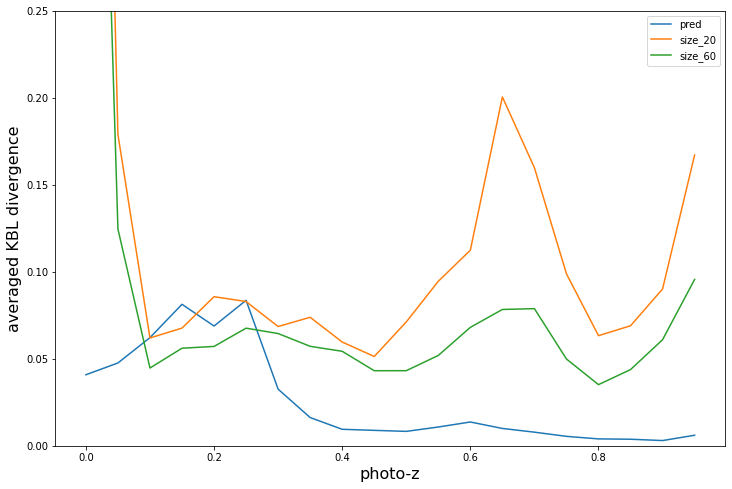

In [184]:
plt.figure(figsize=(12,8))
# for size in latent_sizes[:]:
#     if size!=40:
for name in ['pred', 'size_20', 'size_60']:
        # name = 'size_'+str(size)
    kbl_per_bin, binsz = kbl_plots(My_KBL[name], My_Photoz[name])
    print(np.mean(kbl_per_bin))
    plt.plot(binsz, kbl_per_bin, label=name)
plt.ylabel("averaged KBL divergence", fontsize=16)
plt.xlabel('photo-z', fontsize=16)
plt.legend()
plt.ylim(0, 0.25)